In [9]:
import pandas as pd
import geopandas as gpd
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt

In [10]:
# 1. load your AnnData + total_umi
sample_id = "F07833"
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
                         "dietary_droject/data/cell_segmentation")

adata_path = segmentation_path / sample_id / f"{sample_id}_grouped_filtered_adata.h5ad"
ST_sample = sc.read_h5ad(adata_path)

# compute UMI per cell
ST_sample.obs['total_umis'] = ST_sample.X.sum(axis=1).A1

# 2. load your polygons
gdf = gpd.read_file(
    segmentation_path / sample_id / f"{sample_id}_gdf.gpkg"
)

In [11]:
# # 3. read the csv with your bboxes
# coords = pd.read_csv(
#     "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/"
#     "data/Raw_objects/sample_coords.csv",
#     sep=","
# )

# # pick only the F07833 rows
# secs = coords.query("Fnumber == @sample_id")

# 4. compute centroids & assign section
centroids = gdf.geometry.centroid
gdf['cx'] = centroids.x
gdf['cy'] = centroids.y
gdf['section'] = None

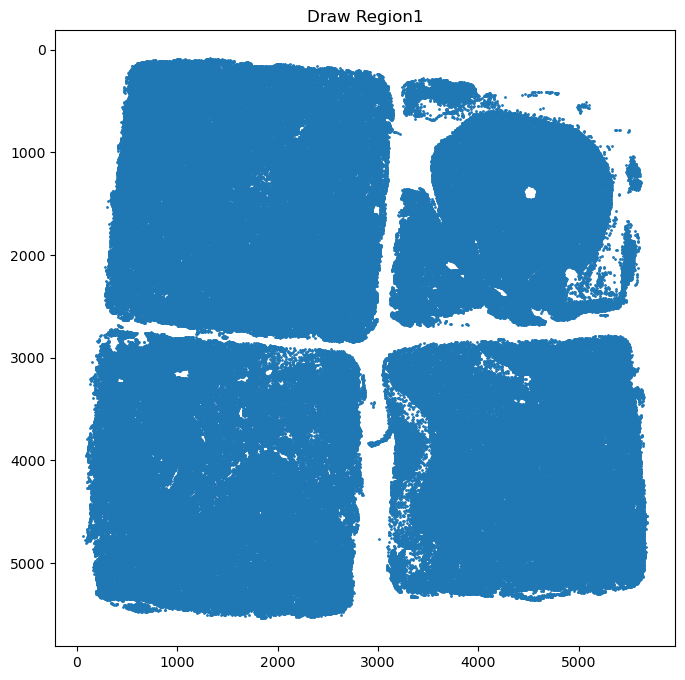

In [12]:
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

# Setup
gdf['region'] = None   # Initialize blank region column
region_counter = [1]   # Mutable counter to track how many regions you select

def onselect(verts):
    path = Path(verts)
    points = gdf[['cx', 'cy']].values
    mask = path.contains_points(points)
    
    # Assign region name
    region_name = f"Region{region_counter[0]}"
    gdf.loc[mask, 'region'] = region_name
    print(f"Selected {mask.sum()} cells for {region_name}")
    
    # Increment region counter
    region_counter[0] += 1
    
    #Update the plot
    ax.clear()
    colors = {
        None: 'lightgray',
        'Region1': 'red',
        'Region2': 'blue',
        'Region3': 'green',
        'Region4': 'orange'
    }
    for region, color in colors.items():
        subset = gdf[gdf['region'] == region]
        ax.scatter(subset['cx'], subset['cy'], s=5, label=region, color=color, alpha=0.7)
    
    ax.invert_yaxis()
    ax.set_title(f"Selected up to Region{region_counter[0]-1}. Draw next region.")
    ax.legend()
    fig.canvas.draw_idle()

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(gdf['cx'], gdf['cy'], s=1)
ax.invert_yaxis()
ax.set_title("Draw Region1")

lasso = LassoSelector(ax, onselect)
plt.show()


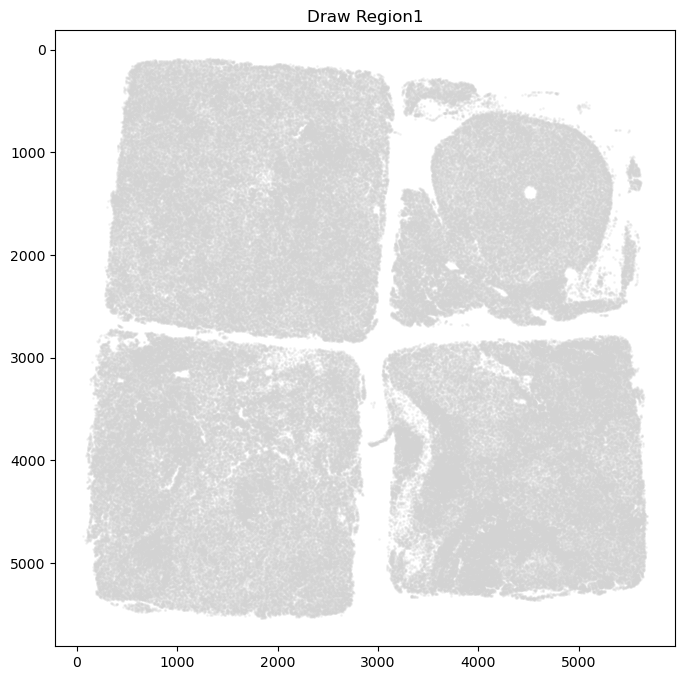

In [13]:
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

# Setup
gdf['region'] = None   # Reset region labels
region_counter = [1]   # Start counter

# 1. Set up initial figure
fig, ax = plt.subplots(figsize=(8, 8))
background = ax.scatter(gdf['cx'], gdf['cy'], s=1, alpha=0.2, color='lightgray')
ax.invert_yaxis()
ax.set_title("Draw Region1")

# 2. Keep track of overlay points
overlay_handles = []

def onselect(verts):
    path = Path(verts)
    points = gdf[['cx', 'cy']].values
    mask = path.contains_points(points)
    
    # Label selected points
    region_name = f"Region{region_counter[0]}"
    gdf.loc[mask, 'region'] = region_name
    print(f"Selected {mask.sum()} cells for {region_name}")
    
    # Draw only the new selection on top
    color_cycle = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
    color = color_cycle[(region_counter[0]-1) % len(color_cycle)]
    
    handle = ax.scatter(
        gdf.loc[mask, 'cx'],
        gdf.loc[mask, 'cy'],
        s=8,
        label=region_name,
        color=color,
        alpha=0.8
    )
    overlay_handles.append(handle)

    # Update title
    region_counter[0] += 1
    ax.set_title(f"Selected up to Region{region_counter[0]-1}. Draw next region.")
    ax.legend(handles=overlay_handles, loc='best')
    
    fig.canvas.draw_idle()

# 3. Set up lasso
lasso = LassoSelector(ax, onselect)
plt.show()
